#**Bishwas Ghimire**
 
Naive Bayes Classifier on the HouseVotes84 data set found here:

https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/




In [0]:
# get the data 
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names

--2019-11-03 02:20:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2019-11-03 02:20:47 (127 KB/s) - ‘house-votes-84.data’ saved [18171/18171]

--2019-11-03 02:20:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6868 (6.7K) [application/x-httpd-php]
Saving to: ‘house-votes-84.names’

house-votes-84.name 100%[======

In [0]:
#read the data into pandas dataframe
import numpy as np
import pandas as pd

df = pd.read_csv(f"/content/house-votes-84.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


From .names file, here are the columns

7. Attribute Information:
   1. Class Name: 2 (democrat, republican)
   2. handicapped-infants: 2 (y,n)
   3. water-project-cost-sharing: 2 (y,n)
   4. adoption-of-the-budget-resolution: 2 (y,n)
   5. physician-fee-freeze: 2 (y,n)
   6. el-salvador-aid: 2 (y,n)
   7. religious-groups-in-schools: 2 (y,n)
   8. anti-satellite-test-ban: 2 (y,n)
   9. aid-to-nicaraguan-contras: 2 (y,n)
  10. mx-missile: 2 (y,n)
  11. immigration: 2 (y,n)
  12. synfuels-corporation-cutback: 2 (y,n)
  13. education-spending: 2 (y,n)
  14. superfund-right-to-sue: 2 (y,n)
  15. crime: 2 (y,n)
  16. duty-free-exports: 2 (y,n)
  17. export-administration-act-south-africa: 2 (y,n)

  Let's put these onto the columns

In [0]:
# add column names
bills = ['party',
         'infants',
         'water',
         'budget',
         'physician',
         'elsalvador',
         'religious',
         'satellite',
         'contras',
         'missile',
         'immigration',
         'synfuels',
         'education',
         'superfund',
         'crime',
         'duty-free',
         'south-africa',
         ]
df.columns = bills
df.head()

,party,infants,water,budget,physician,elsalvador,religious,satellite,contras,missile,immigration,synfuels,education,superfund,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [0]:
#replace yes/no with True/False
df.replace({'y':True, 'n':False, '?':np.nan}, inplace=True)
df.head()

,party,infants,water,budget,physician,elsalvador,religious,satellite,contras,missile,immigration,synfuels,education,superfund,crime,duty-free,south-africa
0,republican,False,True,False,True,True,True,False,False,False,True,NaN,True,True,True,False,True
1,republican,False,True,False,True,True,True,False,False,False,False,False,True,True,True,False,NaN
2,democrat,NaN,True,True,NaN,True,True,False,False,False,False,True,False,True,True,False,False
3,democrat,False,True,True,False,NaN,True,False,False,False,False,True,False,True,False,False,True
4,democrat,True,True,True,False,True,True,False,False,False,False,True,NaN,True,True,True,True


In [0]:
# extract features
X = df.iloc[:,1:]
X.head()

,infants,water,budget,physician,elsalvador,religious,satellite,contras,missile,immigration,synfuels,education,superfund,crime,duty-free,south-africa
0,False,True,False,True,True,True,False,False,False,True,NaN,True,True,True,False,True
1,False,True,False,True,True,True,False,False,False,False,False,True,True,True,False,NaN
2,NaN,True,True,NaN,True,True,False,False,False,False,True,False,True,True,False,False
3,False,True,True,False,NaN,True,False,False,False,False,True,False,True,False,False,True
4,True,True,True,False,True,True,False,False,False,False,True,NaN,True,True,True,True


In [0]:
# extract target
y = df['party']
y.head()
y.value_counts()

democrat      267
republican    168
Name: party, dtype: int64

In [0]:
# drop rows with all nan values
# this causes issues when computing nanmean across rows
nan_rows = np.sum(X.isnull(),axis=1)==X.shape[1]
nan_idx = X[nan_rows].index.copy()
X = X.drop(nan_idx)
y = y.drop(nan_idx)
X.shape[0] == y.shape[0]


True

In [0]:
# do the test-train split for cross-validation before imputing
 from sklearn.model_selection import train_test_split
 X_train_org, X_test_org, y_train, y_test = train_test_split(
     X, y, test_size=0.15, random_state=5)

We'd like to apply sci-kit learn's Naive Bayes (the Bernoulli one since the features and targets are bool).  But we get errors due to the "?" entries, so let's impute the "?" entries using four different imputing strategies.
* using row mean: Fill with most frequent vote cast by the congressperson
* using column mean: Fill with most frequent vote cast on that bill
* with party (2 variants).  Let p = proportion of member's party that voted "Y" for that bill.
  - with party deterministic:  member votes "Y" iff p >= 0.5
  - with party probabilistic:  member votes "Y" with probability p

In [0]:
########################################
######### IMPUTE MISSING VALUES ########

def to_bool(vals):
    return (vals >=0.5).astype('bool')

def impute_idx(X):
    return X.isnull()

def impute(X,method): #uses a copy of X, doesn't change the original X
    idx = impute_idx(X)
    X_copy = X.copy()
    if method == 1: #using row mean
      impute_vals = to_bool(X_copy.T.fillna(X_copy.T.mean(),axis=0).T)
    elif method == 2: #using 'with party: probabilistic'
      impute_vals = X_copy.groupby(y).transform(lambda x: np.mean(x,axis=0))
    elif method == 3: #using 'with party: deterministic'
      impute_vals = to_bool(X_copy.groupby(y).transform(lambda x: 
                                                        np.mean(x,axis=0)))
    else: #using column mean, which is also the default 
      impute_vals = to_bool(X_copy.fillna(X_copy.mean(),axis=0))  
    imputed = X.copy()
    imputed[idx] = impute_vals[idx]
    return imputed

##ALTERNATIVE way to impute using row and column mean
# impute_vals_c = X.T.apply(lambda x: np.nanmean(X, axis=0)).T
# impute_vals_r = X.apply(lambda x: np.nanmean(X, axis=1))

We will use BernoulliNB since all our categorigal variables are binary. We will use k=10 fold cross-validation and tune the hyperparamter, $\alpha$ for all four imputing methods. We plot model performance results for all four cases below. 

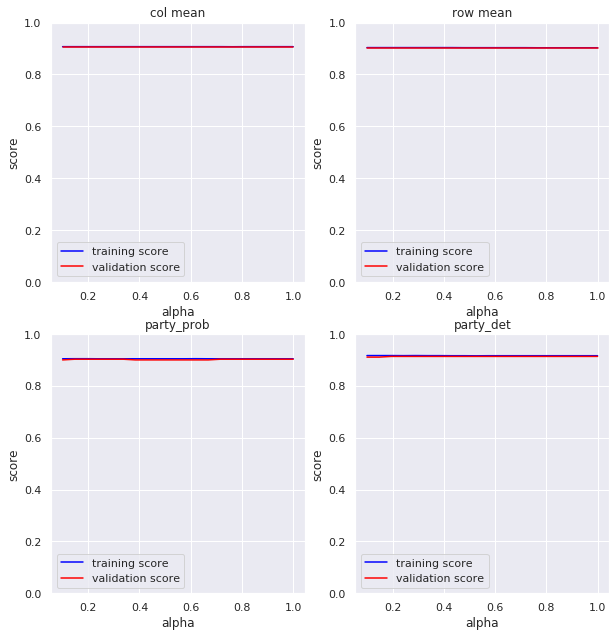

In [0]:
# standard imports
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import validation_curve, GridSearchCV
from sklearn.metrics import accuracy_score 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#initialize model and set model parameters
model = BernoulliNB()
alpha = np.linspace(0.1,1,20)
k = 10

fig = plt.figure()
method = ['col mean', 'row mean', 'party_prob', 'party_det']
for i,label in zip(range(4),method):
    X_train = impute(X_train_org,i)
    X_test  = impute(X_test_org,i)
    train_score, val_score = validation_curve(model, X_train, y_train,
                                          'alpha', alpha, cv=k)
    #plot the results
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(label)
    ax.plot(alpha, np.mean(train_score, 1), 
            color='blue', label='training score')
    ax.plot(alpha, np.mean(val_score, 1), 
            color='red', label='validation score')
    ax.legend(loc='best')
    ax.set_ylim(0, 1)
    ax.set_xlabel('alpha')
    ax.set_ylabel('score')
#plt.tight_layout()
fig.set_size_inches(10, 10.5)
plt.show()

Important notes: 
* df.transform applies to one column at a time as a series object
* df.apply applies to all columns in the dataframe at the same time
* alternative way to impute using row and column mean
>impute_vals_c = X.T.apply(lambda x: np.nanmean(X, axis=0)).T   
>impute_vals_r = X.apply(lambda x: np.nanmean(X, axis=1))


Let's use sci-kit learn's BernoulliNB (for Naive Bayes with bool target) and validation_curve (to tune alpha and to do k-fold cross-validation) on the imputed dataset.

Let's use sci-kit learn's GridsearchCV to find the best estimator.

In [0]:
# use gridsearch to find the best parameter
from sklearn.model_selection import GridSearchCV

#initialize model and set model parameters
model = BernoulliNB()
alpha = np.linspace(0.1,1,1)
k = 7

param_grid = {'alpha': alpha}
grid = GridSearchCV(model, param_grid, cv=k)

for i,label in zip(range(4),method):
    X_train = impute(X_train_org,i)
    X_test  = impute(X_test_org,i)

    grid.fit(X_train,y_train)
    print('best estimator with imputing method',\
          f'{label}:  {grid.best_estimator_}')
    print('best validation score with imputing method',\
          f'{label}: {grid.best_score_}')

    best_model = grid.best_estimator_
    y_pred = best_model.fit(X_train, y_train).predict(X_test)
    accuracy_score(y_test, y_pred)


best estimator with imputing method col mean:  BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)
best validation score with imputing method col mean: 0.904891304347826
best estimator with imputing method row mean:  BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)
best validation score with imputing method row mean: 0.9021739130434783
best estimator with imputing method party_prob:  BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)
best validation score with imputing method party_prob: 0.904891304347826
best estimator with imputing method party_det:  BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)
best validation score with imputing method party_det: 0.9130434782608695


Imputing using deterministic variant of 'with party votes' method has the best performance with 91.3% accuracy in the validation set. Hyperparameter $\alpha$ doesn't really have much influence on model performance which is demonstrated by the plots above. 